# Analyzing Clinical Trials Data using Snowflake and ThoughtSpot
### Persistent Systems Inc. 
### Author: Avadhoot Agasti

ThoughtSpot and Snowflake recently announced tight integration of their offerings. In the recently concluded Beyond 2019 (ThoughtSpot annual conference) in Dallas, ThoughtSpot showed how data stored in Snowflake can be analyzed in ThoughtSpot.

Since we have deep partnership with both Snowflake and ThoughtSpot, we are obviously pretty excited with this. We have our own point of view on how to integrate the two products to make sure we are extracting the best from both of them. As a starter, this 2 blog series explains how to analyze publicly available clinical trials data using Snowflake and ThoughtSpot. The part1 of the blog focuses on ingesting this data (in XML format) into Snowflake and preparing it for analysis in ThoughtSpot. The part2 of the blog will focus on how to connect Snowflake to ThoughtSpot and how to analyze it. 

### Dataset used
For this demo, we have used Clinical Trials Data which is publically available on 
https://clinicaltrials.gov/ct2/search/advanced

Search term used – Heart Attack (no other filters used)

Found 1497 studies

Selected option of Downloading ZIP file for ALL studies

This creates a zip file and downloads it.


### Data Flow
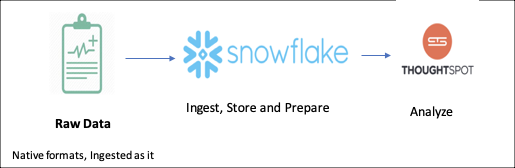

## Data Ingestion

The Python code below explains various steps involved in loading the data into Snowflake and then preparing it for analyzing in ThoughtSpot. 

In the process, I also explain various constructs using which XML can we queried in Snowflake. 

#### Read Snowflake Config Details and open Snowflake Connection

Just pull the credentials from the config file. This file is similar to typical properties file (key=value pair). 

In [1]:
from configparser import ConfigParser
config = ConfigParser()
config.read('config.properties')
# get config data
account = config.get('DatabaseSection', 'account')
user = config.get('DatabaseSection', 'user')
password = config.get('DatabaseSection', 'password')
data_path = config.get('DataSection', 'path')

#### Connect to Snowflake

In [58]:
import snowflake.connector
from pandas import DataFrame

ctx = snowflake.connector.connect(
user=user,
password=password,
account=account
)

#### Some utility functions

In [30]:
def execSQL(sql):
    ctx.cursor().execute(sql)
    
def execSQLAndGetDF(sql, max_rows = 10000):
    try:
        cur = ctx.cursor()
        cs = cur.execute(sql)
        rows = cs.fetchmany(max_rows)
    finally:
        cs.close()
    df = DataFrame(rows)
    df.columns = [col[0] for col in cur.description]
    return df

#### Setup database, schema, virtual warehouse to be used

In [78]:
execSQL("USE DATABASE HealthCareSolution")
execSQL("USE SCHEMA ClinicalTrials")
execSQL("USE WAREHOUSE LoadWH")
execSQL("CREATE STAGE IF NOT EXISTS ClinicalTrialXMLStage")
SQL = "CREATE OR REPLACE FILE FORMAT ClinicalTrialXMLFileFormat \
       TYPE = 'XML' \
       COMPRESSION = 'AUTO' PRESERVE_SPACE = FALSE \
       STRIP_OUTER_ELEMENT = FALSE \
       DISABLE_SNOWFLAKE_DATA = FALSE \
       DISABLE_AUTO_CONVERT = FALSE \
       IGNORE_UTF8_ERRORS = TRUE;"
execSQL(SQL)

#### Push data to stage and copy into Snowflake table

In [12]:
#Upload data to Stage
execSQL("PUT file://" + data_path  + 
        "* @ClinicalTrialXMLStage/heart_attack")
#create table
execSQL("CREATE TABLE IF NOT EXISTS ClinicalTrialsXML (X Variant);")
#Copy data from stage to the table
execSQL("COPY INTO ClinicalTrialsXML FROM \
        @ClinicalTrialXMLStage/heart_attack/  \
        FILE_FORMAT = ClinicalTrialXMLFileFormat \
        on_error = continue;")

#### Basic verification using record count

In [20]:
sql = "SELECT count(*) FROM ClinicalTrialsXML;"

try:
    cs = ctx.cursor().execute(sql)
    rows = cs.fetchone()
    print("Record Count = ", rows[0])
finally:
    cs.close()

Record Count =  1498


## Query XML Nodes
The section below explains how to use XML constructs to find nodes like condition, minimum age, maximum age and show it 

#### Use XMLGet to reach to a XML node.

In [40]:
#Get min/max age. Note that 'condition' is an array and this query only brings in one of the conditions
sql = "SELECT \
GET(XMLGET(XMLGET(X, 'id_info', 0), 'nct_id', 0), '$') as nct_id, \
GET(XMLGET(X, 'condition', 0), '$') as condition_value, \
GET(XMLGET(XMLGET(X, 'eligibility', 0), 'minimum_age', 0), '$') \
    as min_age,\
GET(XMLGET(XMLGET(X, 'eligibility', 0), 'maximum_age', 0), '$') \
    as max_age \
FROM ClinicalTrialsXML limit 50;"

df = execSQLAndGetDF(sql)
df.head(3)

,NCT_ID,CONDITION_VALUE,MIN_AGE,MAX_AGE
0,"""NCT00000542""","""Diabetes Mellitus""","""55 Years""","""100 Years"""
1,"""NCT00001629""","""Myocardial Infarction""","""N/A""","""N/A"""
2,"""NCT00050765""","""Myocardial Infarction""","""18 Years""","""80 Years"""


#### Use of powerful lateral flatten function

In [42]:
#--To Get ALL conditions, not only first one, we need to use lateral flatten
sql = "SELECT \
GET(XMLGET(XMLGET(X, 'id_info', 0), 'nct_id', 0), '$') as nct_id, \
GET(XMLGET(XMLGET(X, 'eligibility', 0), 'minimum_age', 0), '$') \
    as min_age,\
GET(XMLGET(XMLGET(X, 'eligibility', 0), 'maximum_age', 0), '$') as \
    max_age,\
GET(condition_array.value, '$') as condition_value \
FROM ClinicalTrialsXML, \
     lateral flatten (ClinicalTrialsXML.X:\"$\") condition_array \
where condition_array.value like '<condition>%' \
limit 500;"
df = execSQLAndGetDF(sql)
df.head(5)

,NCT_ID,MIN_AGE,MAX_AGE,CONDITION_VALUE
0,"""NCT00000542""","""55 Years""","""100 Years""","""Cardiovascular Diseases"""
1,"""NCT00000542""","""55 Years""","""100 Years""","""Coronary Disease"""
2,"""NCT00000542""","""55 Years""","""100 Years""","""Diabetes Mellitus"""
3,"""NCT00000542""","""55 Years""","""100 Years""","""Heart Diseases"""
4,"""NCT00000542""","""55 Years""","""100 Years""","""Hypercholesterolemia"""


#### Create view for ease of use

In [43]:
#--Lets create a view of this for ease of use
sql = "CREATE OR REPLACE VIEW trial_condition_age_view AS \
SELECT \
GET(XMLGET(XMLGET(X, 'id_info', 0), 'nct_id', 0), '$') as nct_id, \
GET(XMLGET(XMLGET(X, 'eligibility', 0), 'minimum_age', 0), '$') \
    as min_age, \
GET(XMLGET(XMLGET(X, 'eligibility', 0), 'maximum_age', 0), '$') \
    as max_age, \
GET(condition_array.value, '$') as condition_value \
FROM ClinicalTrialsXML, \
     lateral flatten (ClinicalTrialsXML.X:\"$\") condition_array \
where condition_array.value like '<condition>%';"
execSQL(sql)

sql = "select * from trial_condition_age_view limit 10;"
df = execSQLAndGetDF(sql)
df.head(5)

,NCT_ID,MIN_AGE,MAX_AGE,CONDITION_VALUE
0,"""NCT00000542""","""55 Years""","""100 Years""","""Cardiovascular Diseases"""
1,"""NCT00000542""","""55 Years""","""100 Years""","""Coronary Disease"""
2,"""NCT00000542""","""55 Years""","""100 Years""","""Diabetes Mellitus"""
3,"""NCT00000542""","""55 Years""","""100 Years""","""Heart Diseases"""
4,"""NCT00000542""","""55 Years""","""100 Years""","""Hypercholesterolemia"""


In [48]:
#Lets do some data cleanup
sql = "CREATE OR REPLACE VIEW trial_condition_age_view_cleaned AS \
select \
trim(nct_id, '\"') as nct_id, \
trim(condition_value, '\"') as condition_value, \
(replace(strtok(min_age, ' ', 1), 'N/A', '0'))::int as min_age, \
(replace(strtok(max_age, ' ', 1), 'N/A', '0'))::int as max_age \
from trial_condition_age_view;"
execSQL(sql)

sql = "select * from trial_condition_age_view_cleaned limit 10;"
df = execSQLAndGetDF(sql)
df.head(5)

,NCT_ID,CONDITION_VALUE,MIN_AGE,MAX_AGE
0,NCT00000542,Cardiovascular Diseases,55,100
1,NCT00000542,Coronary Disease,55,100
2,NCT00000542,Diabetes Mellitus,55,100
3,NCT00000542,Heart Diseases,55,100
4,NCT00000542,Hypercholesterolemia,55,100


#### Running Analytical queries

In [52]:
#Lets run some analytical queries - finding top conditions in teenagers
sql = "\
select condition_value, count(*) as number_of_trials \
from trial_condition_age_view_cleaned \
where min_age > 12 and max_age < 20 \
group by condition_value \
order by number_of_trials desc \
limit 10;"
df = execSQLAndGetDF(sql)
df.head(5)

,CONDITION_VALUE,NUMBER_OF_TRIALS
0,Myocardial Infarction,303
1,Acute Myocardial Infarction,115
2,Coronary Artery Disease,89
3,Acute Coronary Syndrome,50
4,Unstable Angina,26


## Data Preperation

BI tools like ThoughtSpot does not understand XML. So, we need to create views on top of XML so that we can expose flattend (relational) data to ThoughtSpot. In Snowflake, we can simply create views on top of XML data. 

In this example, we will create two views
1. ClinicalTrialSummary view: This view contains one entry per trial and has all the fields which have 1:1 relation with each clinical trial

2. ClinicalTrialConditions view: There are certain fields in XML which has 1:M relationship. For example, one trial can have multiple 'conditions'. Lets create separate view for this

In [61]:
#Lets convert this XML into tabular views which can be easily analyzed in a BI tool
#ClinicalTrialSummary view: This view contains one entry per trial and has all the fields 
#which have 1:1 relation with each clinical trial
sql = "\
CREATE OR REPLACE VIEW clinical_trial_summary_stage AS \
SELECT  \
GET(XMLGET(XMLGET(X, 'id_info', 0), 'nct_id', 0), '$') \
    as nct_id, \
GET(XMLGET(XMLGET(X, 'id_info', 0), 'org_study_id', 0), '$') \
    as org_study_id, \
GET(XMLGET(X, 'brief_title', 0), '$') as brief_title, \
GET(XMLGET(XMLGET(X, 'brief_summary', 0), 'textblock', 0), '$') \
    as brief_summary, \
GET(XMLGET(X, 'overall_status', 0), '$') as overall_status, \
GET(XMLGET(X, 'start_date', 0), '$') as start_date, \
GET(XMLGET(X, 'completion_date', 0), '$') as completion_date, \
GET(XMLGET(X, 'completion_date', 0), '@type') \
    as completion_date_type, \
GET(XMLGET(X, 'phase', 0), '$') as phase_value, \
GET(XMLGET(X, 'study_type', 0), '$') as study_type, \
GET(XMLGET(XMLGET(X, 'primary_outcome', 0), 'measure', 0), '$') \
    as primary_outcome_measure, \
GET(XMLGET(XMLGET(X, 'primary_outcome', 0), 'time_frame', 0), '$') \
    as primary_outcome_measure_time_frame, \
GET(XMLGET(XMLGET(X, 'eligibility', 0), 'minimum_age', 0), '$') \
    as eligibility_min_age, \
GET(XMLGET(XMLGET(X, 'eligibility', 0), 'maximum_age', 0), '$') \
    as eligibility_max_age \
FROM ClinicalTrialsXML;"

execSQL(sql)

#CLEANUP STRINGS, NUMBERS ETC. clinical_trial_summary_stage is our final view
#Also convert dates to propoer data datatype. 
#We have 2 types of date formats -> jan 2012 and jan 28, 2012. Need to handle both.
sql = "\
CREATE OR REPLACE VIEW clinical_trial_summary AS \
SELECT \
trim(nct_id, '""') as nct_id, \
trim(org_study_id, '""') as org_study_id, \
trim(brief_title, '""') as brief_title, \
trim(brief_summary, '""') as brief_summary,\
trim(overall_status, '""') as overall_status, \
to_date(case when contains(start_date, ',') then start_date \
        else replace(start_date, ' ', ' 01,') end, 'MON DD, YYYY') as start_date, \
to_date(case when contains(completion_date, ',') then completion_date \
        else replace(completion_date, ' ', ' 01,') end, 'MON DD, YYYY') as completion_date, \
trim(completion_date_type, '""') as completion_date_type, \
trim(phase_value, '""') as phase_value, \
trim(study_type, '""') as study_type, \
trim(primary_outcome_measure, '""') as primary_outcome_measure, \
trim(primary_outcome_measure_time_frame, '""') \
     as primary_outcome_measure_time_frame, \
(replace(strtok(eligibility_min_age, ' ', 1), 'N/A', '0'))::int \
     as eligibility_min_age, \
(replace(strtok(eligibility_max_age, ' ', 1), 'N/A', '0'))::int \
     as eligibility_max_age \
FROM clinical_trial_summary_stage;"

execSQL(sql)


#ClinicalTrialConditions view: 
#There are certain fields in XML which has 1:M relationship. For example, one trial can have multiple conditions. 
#Lets create separate view for this
sql = " \
CREATE OR REPLACE VIEW clinical_trial_conditions AS \
SELECT \
trim(GET(XMLGET(XMLGET(X, 'id_info', 0), 'nct_id', 0), '$'), '\"') \
     as nct_id, \
trim(GET(XMLGET(XMLGET(X, 'id_info', 0), 'org_study_id', 0), '$'), '\"') \
     as org_study_id,\
trim(GET(condition_array.value, '$'), '\"') as condition_value \
FROM ClinicalTrialsXML, \
     lateral flatten (ClinicalTrialsXML.X:\"$\") condition_array \
where condition_array.value like '<condition>%';"
execSQL(sql)

#We can join clinical_trial_summary and clinical_trial_conditions
sql = " \
SELECT \
cs.nct_id, cs.org_study_id, cs.brief_title, cs.start_date, cs.phase_value, \
cond.condition_value \
FROM clinical_trial_summary cs INNER JOIN clinical_trial_conditions cond \
ON(cs.nct_id = cond.nct_id and cs.org_study_id = cond.org_study_id) \
limit 10;"
df = execSQLAndGetDF(sql)
df.head(5)

,NCT_ID,ORG_STUDY_ID,BRIEF_TITLE,START_DATE,PHASE_VALUE,CONDITION_VALUE
0,NCT00000542,85,Antihypertensive and Lipid-Lowering Treatment ...,1993-08-01,Phase 3,Cardiovascular Diseases
1,NCT00000542,85,Antihypertensive and Lipid-Lowering Treatment ...,1993-08-01,Phase 3,Coronary Disease
2,NCT00000542,85,Antihypertensive and Lipid-Lowering Treatment ...,1993-08-01,Phase 3,Diabetes Mellitus
3,NCT00000542,85,Antihypertensive and Lipid-Lowering Treatment ...,1993-08-01,Phase 3,Heart Diseases
4,NCT00000542,85,Antihypertensive and Lipid-Lowering Treatment ...,1993-08-01,Phase 3,Hypercholesterolemia


In the above section, we created 2 views - summary and condition which basically act as normalized table. We can also create one direct view on original XML to include all fields from summary and conditions views. This will reduce the cost of join. 

In [80]:
sql = " \
CREATE OR REPLACE VIEW clinical_trial_summary_and_conditions AS \
SELECT \
trim(GET(XMLGET(XMLGET(X, 'id_info', 0), 'nct_id', 0), '$'), '\"') \
     as nct_id, \
trim(GET(XMLGET(XMLGET(X, 'id_info', 0), 'org_study_id', 0), '$'), '\"') \
     as org_study_id,\
trim(GET(condition_array.value, '$'), '\"') as condition_value, \
trim(GET(XMLGET(X, 'brief_title', 0), '$'), '\"') as brief_title, \
trim(GET(XMLGET(XMLGET(X, 'brief_summary', 0), 'textblock', 0), '$'), '\"') \
    as brief_summary, \
trim(GET(XMLGET(X, 'overall_status', 0), '$'), '\"') as overall_status, \
trim(GET(XMLGET(X, 'start_date', 0), '$'), '\"') as start_date_str, \
trim(GET(XMLGET(X, 'completion_date', 0), '$'), '\"') as completion_date_str, \
to_date(case when contains(start_date_str, ',') then start_date_str \
        else replace(start_date_str, ' ', ' 01,') end, 'MON DD, YYYY') as start_date, \
to_date(case when contains(completion_date_str, ',') then completion_date_str \
        else replace(completion_date_str, ' ', ' 01,') end, 'MON DD, YYYY') as completion_date, \
trim(GET(XMLGET(X, 'completion_date', 0), '@type'), '\"') \
    as completion_date_type, \
trim(GET(XMLGET(X, 'phase', 0), '$'), '\"') as phase_value, \
trim(GET(XMLGET(X, 'study_type', 0), '$'), '\"') as study_type, \
trim(GET(XMLGET(XMLGET(X, 'primary_outcome', 0), 'measure', 0), '$'), '\"') \
    as primary_outcome_measure, \
trim(GET(XMLGET(XMLGET(X, 'primary_outcome', 0), 'time_frame', 0), '$'), '\"') \
    as primary_outcome_measure_time_frame, \
(replace(strtok(trim(GET(XMLGET(XMLGET(X, 'eligibility', 0), 'minimum_age', 0), '$'), '\"'), \
                ' ', 1), 'N/A', '0'))::int \
     as eligibility_min_age, \
(replace(strtok(trim(GET(XMLGET(XMLGET(X, 'eligibility', 0), 'maximum_age', 0), '$'), '\"'), \
                ' ', 1), 'N/A', '0'))::int \
     as eligibility_max_age \
FROM ClinicalTrialsXML, \
     lateral flatten (ClinicalTrialsXML.X:\"$\") condition_array \
where condition_array.value like '<condition>%';"
execSQL(sql)

In [81]:
sql = " \
SELECT \
nct_id, org_study_id, brief_title, start_date, phase_value, \
condition_value \
FROM clinical_trial_summary_and_conditions \
WHERE nct_id  not in('NCT00000542') \
limit 5;"
df = execSQLAndGetDF(sql)
df.head(10)

,NCT_ID,ORG_STUDY_ID,BRIEF_TITLE,START_DATE,PHASE_VALUE,CONDITION_VALUE
0,NCT00000482,1,Coronary Drug Project,1965-04-01,Phase 3,Cardiovascular Diseases
1,NCT00000482,1,Coronary Drug Project,1965-04-01,Phase 3,Coronary Disease
2,NCT00000482,1,Coronary Drug Project,1965-04-01,Phase 3,Heart Diseases
3,NCT00000482,1,Coronary Drug Project,1965-04-01,Phase 3,Myocardial Infarction
4,NCT00000482,1,Coronary Drug Project,1965-04-01,Phase 3,Myocardial Ischemia


Views are now ready and can be analyzed in ThoughtSpot. We will study how to refer to this data in live Snowflake connection within ThoughtSpot.

#### Shutdown cluster

Don't forget to shutdown Snowflake customer when you stop using it. 

In [56]:
ctx.cursor().execute("Alter warehouse LoadWH suspend")